## 01. Imports & Dataset Upload

In [59]:
from datetime import datetime
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import os
import optuna
import json
import hashlib
import joblib
import warnings
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

# Setup
warnings.filterwarnings("ignore")
np.random.seed(42)
RANDOM_STATE = 42

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

ASSET_TYPE = "property"
DATA_PATH = os.environ.get("DATA_PATH", "../data/df_cleaned_no_outliers.csv")
MODEL_BASE_DIR = "../models"

ASSET_CONFIG = {
    "property": {
        "target": "valuation_k",
        "categorical": [
            "location", "energy_class", "has_elevator", "has_garden",
            "has_balcony", "garage", "owner_occupied", "public_transport_nearby"
        ],
        "numeric": [
            "size_m2", "rooms", "bathrooms", "year_built", "floor", "building_floors",
            "humidity_level", "temperature_avg", "noise_level", "air_quality_index",
            "luxury_score", "env_score", "distance_to_center_km", "valuation_k",
            "last_verified_ts"
        ],
        "exclude": [
            "asset_id", "asset_type", "condition_score", "risk_score",
            "prediction_ts", "age_years", "age_category", "luxury_category", "value_segment", "timestamp"
        ],
    },
    "art": {"target": "valuation_k", "categorical": [], "numeric": [], "exclude": []},
}

assert ASSET_TYPE in ASSET_CONFIG, f"Unknown asset_type: {ASSET_TYPE}"
cfg = ASSET_CONFIG[ASSET_TYPE]
cfg["numeric"] = [c for c in cfg["numeric"] if c not in ["last_verified_ts", "valuation_k"]]

## 02. Load Dataset

In [60]:
df = pd.read_csv(DATA_PATH)
logging.info(f"📥 Loaded dataset: {DATA_PATH} | Shape: {df.shape}")

2025-07-29 04:50:35,329 [INFO] 📥 Loaded dataset: ../data/df_cleaned_no_outliers.csv | Shape: (4929, 49)


In [61]:
# Ensure important engineered features are present
logging.info("⚙️ Ensuring required engineered features...")

if "age_years" not in df.columns and "year_built" in df.columns:
    current_year = datetime.utcnow().year
    df["age_years"] = current_year - df["year_built"]

if "price_per_sqm" not in df.columns:
    df["price_per_sqm"] = df["valuation_k"] * 1000 / df["size_m2"]

if "luxury_score" not in df.columns:
    df["luxury_score"] = (df["has_garden"] + df["has_balcony"] + df["garage"]) / 3

if "efficiency_score" not in df.columns:
    df["efficiency_score"] = (
        (df["valuation_k"] / df["size_m2"]) * (1 + df["luxury_score"])
    )

df = df.drop(columns=["efficiency_score", "price_per_sqm"], errors="ignore")

2025-07-29 04:50:35,650 [INFO] ⚙️ Ensuring required engineered features...


## 03. Normalization / Derivations

In [62]:
# Anno corrente per derivare età immobile
current_year = datetime.utcnow().year

# Correzione naming colonne se necessario
if "year_build" in df.columns and "year_built" not in df.columns:
    df = df.rename(columns={"year_build": "year_built"})

# Calcolo età se mancante
if "age_years" not in df.columns and "year_built" in df.columns:
    df["age_years"] = current_year - df["year_built"]

# Aggiungila alle feature numeriche se presente
if "age_years" in df.columns and "age_years" not in cfg["numeric"]:
    cfg["numeric"].append("age_years")

# Pulizia finale delle colonne exclude
df = df.drop(columns=[col for col in cfg["exclude"] if col in df.columns])

if "year_built" in df.columns:
    current_year = datetime.utcnow().year
    df["age_years"] = current_year - df["year_built"]

logging.info(f"✅ Dataset ready | Shape: {df.shape}")
df.head()

2025-07-29 04:50:36,158 [INFO] ✅ Dataset ready | Shape: (4929, 39)


,location,region,urban_type,size_m2,rooms,bathrooms,year_built,floor,building_floors,has_elevator,...,avg_room_size,location_premium,amenity_count,price_vs_region_avg,size_bin,days_since_verification,hours_since_verification,anomaly_score,anomaly_flag,age_years
0,Catania,south,semiurban,142,5,1,1964,2,7,1,...,28.400000,1.0,3,0.988797,"(135.4, 151.3]",57,1385.142305,1,False,61
1,Florence,center,urban,92,3,2,1987,1,9,1,...,30.666667,1.2,3,0.431235,"(87.7, 103.6]",45,1100.792305,1,False,38
2,Naples,south,urban,54,4,3,2013,0,3,0,...,13.500000,1.2,1,0.633951,"(39.841, 55.9]",44,1069.408971,1,False,12
3,Trieste,northeast,semiurban,129,6,2,2009,3,8,1,...,21.500000,1.0,3,1.369051,"(119.5, 135.4]",22,547.325638,1,False,16
4,Turin,north,urban,43,6,3,1967,1,5,1,...,7.166667,1.2,1,0.203781,"(39.841, 55.9]",53,1292.708971,-1,True,58


## 04. Sanity checks

In [63]:
# Verifica che tutte le colonne richieste siano presenti
required_base = list(set([cfg["target"]] + cfg["categorical"] + cfg["numeric"]))
missing = [col for col in required_base if col not in df.columns]
if missing:
    raise ValueError(f"❌ Missing required columns: {missing}")

# Rimozione duplicati eventuali
cfg["categorical"] = sorted(set(cfg["categorical"]))
cfg["numeric"] = sorted(set(cfg["numeric"]))

# Filtro automatico delle feature non presenti nel dataset
cfg["numeric"] = [col for col in cfg["numeric"] if col in df.columns]
cfg["categorical"] = [col for col in cfg["categorical"] if col in df.columns]

# Determina le colonne usabili come feature
excluded = set(cfg["exclude"] + [cfg["target"]])
feature_candidates = [col for col in df.columns if col not in excluded]

# Logging dettagliato
logging.info("📊 FEATURE SELECTION OVERVIEW")
logging.info(f"🎯 Target: {cfg['target']}")
logging.info(f"🧩 Categorical: {cfg['categorical']}")
logging.info(f"📐 Numeric: {cfg['numeric']}")
logging.info(f"🚫 Excluded: {cfg['exclude']}")
logging.info(f"✅ Feature pool: {feature_candidates}")

2025-07-29 04:50:36,652 [INFO] 📊 FEATURE SELECTION OVERVIEW
2025-07-29 04:50:36,653 [INFO] 🎯 Target: valuation_k
2025-07-29 04:50:36,654 [INFO] 🧩 Categorical: ['energy_class', 'garage', 'has_balcony', 'has_elevator', 'has_garden', 'location', 'owner_occupied', 'public_transport_nearby']
2025-07-29 04:50:36,655 [INFO] 📐 Numeric: ['age_years', 'air_quality_index', 'bathrooms', 'building_floors', 'distance_to_center_km', 'env_score', 'floor', 'humidity_level', 'luxury_score', 'noise_level', 'rooms', 'size_m2', 'temperature_avg', 'year_built']
2025-07-29 04:50:36,656 [INFO] 🚫 Excluded: ['asset_id', 'asset_type', 'condition_score', 'risk_score', 'prediction_ts', 'age_years', 'age_category', 'luxury_category', 'value_segment', 'timestamp']
2025-07-29 04:50:36,657 [INFO] ✅ Feature pool: ['location', 'region', 'urban_type', 'size_m2', 'rooms', 'bathrooms', 'year_built', 'floor', 'building_floors', 'has_elevator', 'has_garden', 'has_balcony', 'garage', 'owner_occupied', 'public_transport_nearby

## 05. Overfitting check

In [64]:
def comprehensive_overfitting_check(pipeline, X_train, X_test, y_train, y_test):
    """
    Analisi completa dell'overfitting tramite MAE su training, test e cross-validation.
    """
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    cv_scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=5,
        scoring="neg_mean_absolute_error",
        n_jobs=-1  # 🔁 sfrutta il parallelismo
    )
    cv_mae = -cv_scores.mean()
    cv_std = cv_scores.std()

    logging.info("\n🔍 OVERFITTING ANALYSIS")
    logging.info("=" * 50)
    logging.info(f"Training MAE: {train_mae:.2f}")
    logging.info(f"CV MAE:       {cv_mae:.2f} ± {cv_std:.2f}")
    logging.info(f"Test MAE:     {test_mae:.2f}")

    if train_mae < cv_mae * 0.5:
        logging.warning("❌ SEVERE OVERFITTING: Train MAE << CV MAE")
    if test_mae > cv_mae * 2:
        logging.warning("❌ POOR GENERALIZATION: Test MAE >> CV MAE")

    return {"train": train_mae, "cv": cv_mae, "test": test_mae}

## 06. Final feature list = categorical + numeric

In [65]:
feature_list = cfg["categorical"] + cfg["numeric"]
logging.info(f"🧮 Final feature list: {feature_list}")

X = df[feature_list].copy()
y = df[cfg["target"]].copy()

2025-07-29 04:50:38,320 [INFO] 🧮 Final feature list: ['energy_class', 'garage', 'has_balcony', 'has_elevator', 'has_garden', 'location', 'owner_occupied', 'public_transport_nearby', 'age_years', 'air_quality_index', 'bathrooms', 'building_floors', 'distance_to_center_km', 'env_score', 'floor', 'humidity_level', 'luxury_score', 'noise_level', 'rooms', 'size_m2', 'temperature_avg', 'year_built']


## 07. Train/test split

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

# Allineamento categorie
for col in X_train.select_dtypes(include="object").columns:
    all_categories = pd.Series(pd.concat([X_train[col], X_test[col]])).astype("category").cat.categories
    X_train[col] = X_train[col].astype("category").cat.set_categories(all_categories)
    X_test[col] = X_test[col].astype("category").cat.set_categories(all_categories)

## 08. Preprocessing + Tuning

In [67]:
df['last_verified_ts']
df['location'], df['energy_class']

(0        Catania
 1       Florence
 2         Naples
 3        Trieste
 4          Turin
           ...   
 4924    Cagliari
 4925      Naples
 4926       Milan
 4927    Cagliari
 4928       Turin
 Name: location, Length: 4929, dtype: object,
 0       F
 1       E
 2       G
 3       C
 4       E
        ..
 4924    D
 4925    A
 4926    B
 4927    C
 4928    D
 Name: energy_class, Length: 4929, dtype: object)

In [68]:
df['location_energy_class'] = (
    df['location'].astype(str) + "_" + df['energy_class'].astype(str)
)

assert "last_verified_ts" in df.columns, "❌ Manca last_verified_ts"
assert "valuation_k" in df.columns, "❌ Manca valuation_k"

X_full = df.drop(columns=["valuation_k"])
y_full = df["valuation_k"]

feature_cols = [c for c in df.columns 
                if c not in ['valuation_k', 'asset_id', 'timestamp',
                             'last_verified_ts', 'location_energy_class']]

X_full = df[feature_cols]
y_full = df['valuation_k']

In [73]:
# --- CODICE COMPLETO PULITO ---

# 1) Preprocessing
missing_cat = [c for c in cfg["categorical"] if c not in X_full.columns]
missing_num = [c for c in cfg["numeric"] if c not in X_full.columns]
if missing_cat or missing_num:
    logging.warning(f"Colonne mancanti → categorical: {missing_cat}, numeric: {missing_num}")

categorical_cols = [c for c in cfg["categorical"] if c in X_full.columns]
numeric_cols = [c for c in cfg["numeric"] if c in X_full.columns]
assert categorical_cols or numeric_cols, "⚠️ Nessuna colonna valida per preprocessing!"

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("num", "passthrough", numeric_cols),
])

# 2) TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
train_idx, valid_idx = next(tscv.split(X_full))
X_tune, X_valid = X_full.iloc[train_idx], X_full.iloc[valid_idx]
y_tune, y_valid = y_full.iloc[train_idx], y_full.iloc[valid_idx]
logging.info(f"[TS] Fold0 → Train: {X_tune.shape}, Valid: {X_valid.shape}")

# 3) Transform
X_tune_enc = preprocessor.fit_transform(X_tune)
X_valid_enc = preprocessor.transform(X_valid)
logging.info(f"🧩 Preprocessed shapes → Tune: {X_tune_enc.shape}, Valid: {X_valid_enc.shape}")

# 4) LightGBM datasets
y_tune_log = np.log1p(y_tune)
y_valid_log = np.log1p(y_valid)
dtrain = lgb.Dataset(data=X_tune_enc, label=y_tune_log)
dvalid = lgb.Dataset(data=X_valid_enc, label=y_valid_log)

# 5) Optuna objective
def objective_function(trial):
    params = {
        "objective": "regression",
        "metric": "mae",
        "boosting_type": "gbdt",
        "verbosity": -1,
        "seed": RANDOM_STATE,
        "learning_rate": 0.01,
        "num_leaves": trial.suggest_int("num_leaves", 20, 80),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "feature_pre_filter": False,
    }
    
    evals_result = {}
    
    model = lgb.train(
        params,
        train_set=dtrain,
        valid_sets=[dvalid],
        valid_names=["valid"],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=0),
            lgb.record_evaluation(evals_result)
        ]
    )
    
    best_iteration = model.best_iteration
    best_score = evals_result['valid']['l1'][best_iteration - 1] if best_iteration > 0 else float('inf')
    
    trial.set_user_attr("best_model", model)
    trial.set_user_attr("best_iteration", best_iteration)
    trial.set_user_attr("best_score", best_score)
    
    return best_score

# 6) Run Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective_function, n_trials=50, show_progress_bar=True)

# 7) Extract results
best_trial = study.best_trial
best_model = best_trial.user_attrs["best_model"]
best_iter_ts = best_trial.user_attrs["best_iteration"]
best_mae_ts = best_trial.user_attrs["best_score"]

# 8) Log ONLY these results
logging.info(f"🎯 Best trial: {best_trial.number}")
logging.info(f"✅ Best parameters: {best_trial.params}")
logging.info(f"✅ TS best_iteration: {best_iter_ts}")
logging.info(f"📉 TS Best MAE (log1p): {best_mae_ts:.4f}")

# RIMUOVI TUTTO IL CODICE SOTTO QUESTA RIGA CHE GENERA I WARNING!
# Non serve più questo codice:
# - if best_iter_ts <= 0: ...
# - best_score_dict = getattr(best_model, "best_score", {}) ...
# - if best_mae_ts is not None: ...
# etc.

# 9) Salva il best model parameters per uso futuro
best_optuna_params = {
    **study.best_params,
    "objective": "regression",
    "metric": "mae",
    "boosting_type": "gbdt",
    "verbosity": -1,
    "seed": RANDOM_STATE,
    "learning_rate": 0.01,
    "n_estimators": best_iter_ts,  # Usa il best iteration come n_estimators
}

logging.info(f"🎯 Final LGBM params: {best_optuna_params}")

2025-07-29 05:01:39,848 [INFO] [TS] Fold0 → Train: (824, 37), Valid: (821, 37)
2025-07-29 05:01:39,868 [INFO] 🧩 Preprocessed shapes → Tune: (824, 48), Valid: (821, 48)
[I 2025-07-29 05:01:39,883] A new study created in memory with name: no-name-e0d616cb-76ec-41c3-a406-5fdf50d99118


  0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[318]	valid's l1: 0.250238
[I 2025-07-29 05:01:40,144] Trial 0 finished with value: 0.25023809274411835 and parameters: {'num_leaves': 30, 'max_depth': 7, 'min_child_samples': 30, 'feature_fraction': 0.7999203021779528, 'bagging_fraction': 0.9988975945363576, 'reg_alpha': 0.39884519067979063, 'reg_lambda': 0.8704689287147821}. Best is trial 0 with value: 0.25023809274411835.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[370]	valid's l1: 0.250847
[I 2025-07-29 05:01:40,399] Trial 1 finished with value: 0.250847044009419 and parameters: {'num_leaves': 50, 'max_depth': 12, 'min_child_samples': 42, 'feature_fraction': 0.6522713353931427, 'bagging_fraction': 0.8884499405135903, 'reg_alpha': 0.4977054879179267, 'reg_lambda': 0.8114807804222434}. Best is trial 0 with value: 0.25023809274411835.
Training until validation scores don't improve for 50 

2025-07-29 05:01:51,589 [INFO] 🎯 Best trial: 49
2025-07-29 05:01:51,590 [INFO] ✅ Best parameters: {'num_leaves': 60, 'max_depth': 11, 'min_child_samples': 45, 'feature_fraction': 0.8800100949787368, 'bagging_fraction': 0.7812723686785915, 'reg_alpha': 0.729114739812065, 'reg_lambda': 0.882750507925878}
2025-07-29 05:01:51,591 [INFO] ✅ TS best_iteration: 326
2025-07-29 05:01:51,591 [INFO] 📉 TS Best MAE (log1p): 0.2480
2025-07-29 05:01:51,606 [INFO] 🎯 Final LGBM params: {'num_leaves': 60, 'max_depth': 11, 'min_child_samples': 45, 'feature_fraction': 0.8800100949787368, 'bagging_fraction': 0.7812723686785915, 'reg_alpha': 0.729114739812065, 'reg_lambda': 0.882750507925878, 'objective': 'regression', 'metric': 'mae', 'boosting_type': 'gbdt', 'verbosity': -1, 'seed': 42, 'learning_rate': 0.01, 'n_estimators': 326}


Early stopping, best iteration is:
[326]	valid's l1: 0.247982
[I 2025-07-29 05:01:51,555] Trial 49 finished with value: 0.247981525311835 and parameters: {'num_leaves': 60, 'max_depth': 11, 'min_child_samples': 45, 'feature_fraction': 0.8800100949787368, 'bagging_fraction': 0.7812723686785915, 'reg_alpha': 0.729114739812065, 'reg_lambda': 0.882750507925878}. Best is trial 49 with value: 0.247981525311835.


## 09. Build pipeline con target transformer

In [74]:
# ——————————————————————————
# 1) Recupero dei parametri ottimali
# ——————————————————————————
# Se hai uno study Optuna:
best_optuna_params = study.best_params.copy()

# Configurazione finale per LGBM
final_params = {
    **best_optuna_params,
    "objective":      "regression",
    "metric":         "mae",
    "boosting_type":  "gbdt",
    "verbosity":      -1,
    "force_col_wise": True,
    "random_state":   RANDOM_STATE,
    "n_jobs":         -1,
    # Assicuriamoci di usare il numero di iterazioni ottimale
    "n_estimators":   max(100, getattr(best_model, "best_iteration", 0))
  
}

logging.info(f"🎯 Final LGBM params: {final_params}")

# ——————————————————————————
# 2) Inizializzazione regressore e pipeline
# ——————————————————————————
lgb_final = lgb.LGBMRegressor(**final_params)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", TransformedTargetRegressor(
        regressor=lgb_final,
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

logging.info("✅ Pipeline with optimized LightGBM + log1p transformation ready.")

2025-07-29 05:02:33,180 [INFO] 🎯 Final LGBM params: {'num_leaves': 60, 'max_depth': 11, 'min_child_samples': 45, 'feature_fraction': 0.8800100949787368, 'bagging_fraction': 0.7812723686785915, 'reg_alpha': 0.729114739812065, 'reg_lambda': 0.882750507925878, 'objective': 'regression', 'metric': 'mae', 'boosting_type': 'gbdt', 'verbosity': -1, 'force_col_wise': True, 'random_state': 42, 'n_jobs': -1, 'n_estimators': 100}
2025-07-29 05:02:33,248 [INFO] ✅ Pipeline with optimized LightGBM + log1p transformation ready.


## 10. Validazione + CV

In [75]:
def validate_training_data(X, y):
    assert isinstance(X, pd.DataFrame), "❌ X must be a pandas DataFrame"
    assert isinstance(y, (pd.Series, pd.DataFrame)), "❌ y must be a pandas Series or DataFrame"
    assert X.shape[0] == y.shape[0], "❌ Features and target misaligned"
    assert not X.isnull().values.any(), "❌ Missing values in X"
    assert not y.isnull().values.any(), "❌ Missing values in y"
    logging.info(f"✅ Training data validated | X: {X.shape}, y: {y.shape}")

# Applichiamo la validazione sul dataset intero
validate_training_data(X_full, y_full)

# ——————————————————————————
# 4) Cross‐validation con TimeSeriesSplit
# ——————————————————————————
tscv = TimeSeriesSplit(n_splits=5)

cv_scores = cross_val_score(
    pipeline,
    X_full,
    y_full,
    cv=tscv,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    n_jobs=-1
)

# Ricordiamo che cross_val_score restituisce MAE negativo
cv_mae = -cv_scores.mean()
cv_std = cv_scores.std()

logging.info("🔁 CROSS-VALIDATION RESULTS (TimeSeriesSplit)")
logging.info(f"✅ MAE: {cv_mae:.2f} ± {cv_std:.2f} k€")

2025-07-29 05:02:35,055 [INFO] ✅ Training data validated | X: (4929, 37), y: (4929,)
2025-07-29 05:02:59,490 [INFO] 🔁 CROSS-VALIDATION RESULTS (TimeSeriesSplit)
2025-07-29 05:02:59,491 [INFO] ✅ MAE: 73.07 ± 1.52 k€


In [76]:
# --- Helper per Prediction Intervals con Quantile Regression ---
def train_quantile_models(X_train, y_train, preprocessor, quantiles=[0.05, 0.5, 0.95]):
    quantile_models = {}
    base_params = {
        k: v for k, v in best_optuna_params.items()
        if k not in ['objective', 'metric', 'n_estimators']
    }

    fallback_estimators = max(100, getattr(best_model, "best_iteration", 100))
    n_estimators = best_optuna_params.get('n_estimators', fallback_estimators)
    if n_estimators <= 0:
        n_estimators = fallback_estimators

    for q in quantiles:
        model_q = lgb.LGBMRegressor(
            objective='quantile',
            alpha=q,
            n_estimators=n_estimators,
            random_state=RANDOM_STATE,
            **base_params
        )
        pipeline_q = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', TransformedTargetRegressor(
                regressor=model_q,
                func=np.log1p,
                inverse_func=np.expm1
            ))
        ])
        pipeline_q.fit(X_train, y_train)
        quantile_models[q] = pipeline_q
        comprehensive_overfitting_check(pipeline_q, X_train, X_test, y_train, y_test)

    return quantile_models

def predict_with_intervals(quantile_models, X):
    """
    DataFrame con predizioni per ciascun quantile.
    """
    intervals = {}
    for q, model in quantile_models.items():
        intervals[f"q{int(q*100)}"] = model.predict(X)
    return pd.DataFrame(intervals, index=X.index)

In [77]:
import logging
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.compose import TransformedTargetRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

# -------------------------------------------
# 1) Split “A/B” per blending (80/20)
# -------------------------------------------
X_A, X_B, y_A, y_B = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True
)
logging.info(f"[Blending] TrainA: {X_A.shape}, TrainB (meta-train): {X_B.shape}")

# -------------------------------------------
# 2) Fit dei base learners su A
# -------------------------------------------
safe_best_iter = max(100, getattr(best_model, "best_iteration", 0))

base_learners = {
    "lgb": TransformedTargetRegressor(
        regressor=lgb.LGBMRegressor(
            **best_optuna_params,
            n_estimators=safe_best_iter,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        func=np.log1p, inverse_func=np.expm1
    ),
    "xgb": TransformedTargetRegressor(
        regressor=XGBRegressor(
            n_estimators=500,
            max_depth=6,
            learning_rate=0.01,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbosity=0
        ),
        func=np.log1p, inverse_func=np.expm1
    ),
    "ridge": TransformedTargetRegressor(
        regressor=Ridge(alpha=1.0, random_state=RANDOM_STATE),
        func=np.log1p, inverse_func=np.expm1
    )
}

for name, learner in base_learners.items():
    learner.fit(preprocessor.fit_transform(X_A), y_A)
    logging.info(f"    • Base learner {name} trained on A")

# -------------------------------------------
# 3) Creazione meta-features su B
# -------------------------------------------
meta_X = np.vstack([
    learner.predict(preprocessor.transform(X_B))
    for learner in base_learners.values()
]).T
meta_y = y_B

# -------------------------------------------
# 4) Nested CV per tuning alpha (meta-learner)
# -------------------------------------------
inner_tscv = TimeSeriesSplit(n_splits=3)
param_grid = {"alpha": [0.01, 0.1, 1.0, 10.0]}

grid_meta = GridSearchCV(
    Ridge(random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=inner_tscv,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    n_jobs=-1,
    refit=True
)
grid_meta.fit(meta_X, meta_y)
best_alpha = grid_meta.best_params_["alpha"]
logging.info(f"🔍 Meta-learner best alpha (nested CV): {best_alpha}")

# -------------------------------------------
# 5) Fit finale del meta-learner
# -------------------------------------------
meta_learner = Ridge(alpha=best_alpha, random_state=RANDOM_STATE)
meta_learner.fit(meta_X, meta_y)
logging.info("    • Meta-learner (Ridge) trained on meta-features")

# -------------------------------------------
# 6) Refit dei base learners su tutto X_full
# -------------------------------------------
for name, learner in base_learners.items():
    learner.fit(preprocessor.fit_transform(X_full), y_full)
    logging.info(f"🔄 Base learner {name} refit on full training data")

# -------------------------------------------
# 7) Funzione blending finale
# -------------------------------------------
def blending_predict(X):
    X_enc = preprocessor.transform(X)
    base_preds = np.vstack([lm.predict(X_enc) for lm in base_learners.values()]).T
    return meta_learner.predict(base_preds)

# -------------------------------------------
# 8) Prediction Intervals con modelli quantili
# -------------------------------------------
if "train_quantile_models" in globals() and "predict_with_intervals" in globals():
    quantiles = [0.05, 0.5, 0.95]
    quantile_models = train_quantile_models(X_train, y_train, preprocessor, quantiles=quantiles)
    pred_intervals = predict_with_intervals(quantile_models, X_test)

    interval_cols = [f"q{int(q*100)}" for q in quantiles]
    lower_col, median_col, upper_col = interval_cols
    logging.info(pred_intervals.head().to_string())

    lower = pred_intervals[lower_col].to_numpy()
    upper = pred_intervals[upper_col].to_numpy()
    actual = y_test.to_numpy()

    coverage = np.mean((actual >= lower) & (actual <= upper))
    avg_width = np.mean(upper - lower)

    logging.info(f"📊 Interval coverage: {coverage:.2%}")
    logging.info(f"📊 Average interval width: {avg_width:.2f} k€")
else:
    logging.warning("⚠️ Funzioni per prediction intervals non trovate.")

# -------------------------------------------
# 9) Valutazione finale sul test set
# -------------------------------------------
y_pred_blend = blending_predict(X_test)
mae_blend    = mean_absolute_error(y_test, y_pred_blend)
rmse_blend   = np.sqrt(mean_squared_error(y_test, y_pred_blend))
r2_blend     = r2_score(y_test, y_pred_blend)

logging.info("📈 FINAL BLENDING EVALUATION ON TEST SET")
logging.info(f"📊 MAE:  {mae_blend:.2f} k€")
logging.info(f"📊 RMSE: {rmse_blend:.2f} k€")
logging.info(f"📊 R²:   {r2_blend:.2f}")

2025-07-29 05:02:59,538 [INFO] [Blending] TrainA: (3943, 37), TrainB (meta-train): (986, 37)
2025-07-29 05:02:59,696 [INFO]     • Base learner lgb trained on A
2025-07-29 05:03:00,405 [INFO]     • Base learner xgb trained on A
2025-07-29 05:03:00,427 [INFO]     • Base learner ridge trained on A
2025-07-29 05:03:00,653 [INFO] 🔍 Meta-learner best alpha (nested CV): 10.0
2025-07-29 05:03:00,655 [INFO]     • Meta-learner (Ridge) trained on meta-features
2025-07-29 05:03:00,808 [INFO] 🔄 Base learner lgb refit on full training data
2025-07-29 05:03:01,625 [INFO] 🔄 Base learner xgb refit on full training data
2025-07-29 05:03:01,645 [INFO] 🔄 Base learner ridge refit on full training data
2025-07-29 05:03:02,610 [INFO] 
🔍 OVERFITTING ANALYSIS
2025-07-29 05:03:02,611 [INFO] ==================================================
2025-07-29 05:03:02,611 [INFO] Training MAE: 107.99
2025-07-29 05:03:02,612 [INFO] CV MAE:       112.86 ± 1.17
2025-07-29 05:03:02,612 [INFO] Test MAE:     105.79
2025-07-29

In [78]:
from sklearn.base import clone

lgb_pipeline_check = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", clone(base_learners["lgb"]))
])
lgb_pipeline_check.fit(X_train, y_train)

comprehensive_overfitting_check(
    pipeline=lgb_pipeline_check,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

2025-07-29 05:03:05,124 [INFO] 
🔍 OVERFITTING ANALYSIS
2025-07-29 05:03:05,125 [INFO] ==================================================
2025-07-29 05:03:05,125 [INFO] Training MAE: 45.37
2025-07-29 05:03:05,126 [INFO] CV MAE:       70.92 ± 0.17
2025-07-29 05:03:05,126 [INFO] Test MAE:     71.00


{'train': 45.36749695926591,
 'cv': np.float64(70.92287434133483),
 'test': 71.00200019646881}

## 12. Feature Importance

In [ ]:
from IPython.display import display

# 🔍 FEATURE IMPORTANCE ANALYSIS (LightGBM base learner)
logging.info("🧠 Analyzing feature importances from the LGBM base learner in the blending model...")

# 1) Estrai i nomi delle feature dopo OneHotEncoder dal preprocessor
try:
    ohe = preprocessor.named_transformers_["cat"]
    encoded_cat = list(ohe.get_feature_names_out(categorical_cols))
except Exception as e:
    logging.error(f"❌ Errore estrazione OHE features: {e}")
    encoded_cat = []

# 2) Combina feature one-hot + numeriche
feature_names = encoded_cat + numeric_cols

# 3) Estrai il booster LightGBM dal base learner
lgb_booster = base_learners["lgb"].regressor_.booster_

# 4) Importanza delle feature per gain
gain_importances = lgb_booster.feature_importance(importance_type="gain")

feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "gain_importance": gain_importances
})

# 5) Calcola la permutation importance
from sklearn.inspection import permutation_importance

try:
    # ➤ X_test dev'essere preprocessato
    X_test_enc = preprocessor.transform(X_test)
    # ➤ y_test dev'essere trasformato con log1p perché usato da .regressor_
    y_test_transformed = np.log1p(y_test)

    perm = permutation_importance(
        estimator=base_learners["lgb"].regressor_,
        X=X_test_enc,
        y=y_test_transformed,
        n_repeats=5,
        random_state=RANDOM_STATE,
        scoring="neg_mean_absolute_error"
    )

    perm_df = pd.DataFrame({
        "feature": feature_names,
        "perm_importance": perm.importances_mean
    })

    feat_imp_df = feat_imp_df.merge(perm_df, on="feature", how="left")

except Exception as e:
    logging.error(f"❌ Errore durante la permutation importance: {e}")
    feat_imp_df["perm_importance"] = np.nan

# 6) Mostra le prime 10
top_feats = feat_imp_df.sort_values("gain_importance", ascending=False).head(10)
logging.info("🏆 Top 10 features by gain importance (and permutation):")
display(top_feats)

2025-07-29 05:03:05,142 [INFO] 🧠 Analyzing feature importances from the LGBM base learner in the blending model...
2025-07-29 05:03:06,218 [INFO] 🏆 Top 10 features by gain importance (and permutation):


,feature,gain_importance,perm_importance
45,size_m2,4528.110522,0.326465
35,air_quality_index,115.730495,0.022010
46,temperature_avg,114.845225,0.020243
41,humidity_level,113.536855,0.018875
38,distance_to_center_km,109.344762,0.021971
34,age_years,91.950490,0.016905
43,noise_level,82.822101,0.016468
42,luxury_score,35.191802,0.013233
37,building_floors,24.655003,0.004913
40,floor,22.696806,0.007350


## 13. Aggregated Importance

2025-07-29 05:03:06,244 [INFO] 📊 Aggregated importance by categorical feature:


,aggregated_importance
location,17.175113
energy_class,15.865392
owner_occupied,9.499525
has_garden,7.017344
has_balcony,4.563937
garage,2.926362
public_transport_nearby,0.663126
has_elevator,0.495110


,aggregated_importance,perm_importance
location,17.175113,0.005153
energy_class,15.865392,0.005505
owner_occupied,9.499525,0.003406
has_garden,7.017344,0.002737
has_balcony,4.563937,0.006466
garage,2.926362,0.000323
public_transport_nearby,0.663126,0.000434
has_elevator,0.495110,0.000036


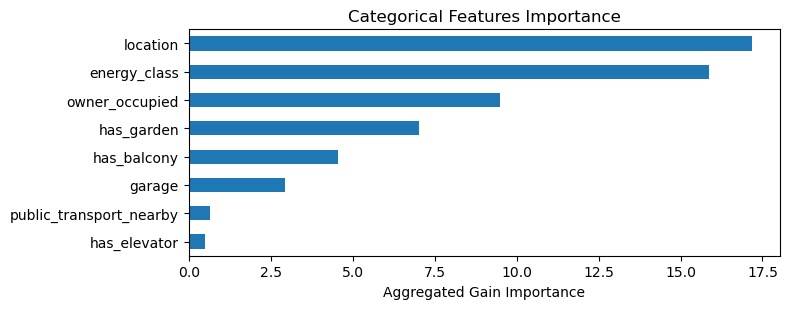

In [80]:
import re
from typing import Dict, List

def get_categorical_importance_summary(
    feat_importance: pd.DataFrame,
    categorical_cols: List[str],
    importance_col: str = "gain_importance",
    normalize: bool = False
) -> Dict[str, float]:
    """
    Calcola l'importanza aggregata per ogni colonna categorica originale.
    """
    cat_importance: Dict[str, float] = {}
    for col in categorical_cols:
        pattern = re.compile(rf"^{re.escape(col)}_")
        sub_feats = [f for f in feat_importance["feature"] if pattern.match(f)]
        if not sub_feats:
            cat_importance[col] = 0.0
            continue
        total = feat_importance.loc[
            feat_importance["feature"].isin(sub_feats), importance_col
        ].sum()
        if normalize:
            total /= len(sub_feats)
        cat_importance[col] = total
    return cat_importance

# 1) Calcolo aggregated gain importance
cat_imp = get_categorical_importance_summary(
    feat_imp_df, categorical_cols, importance_col="gain_importance", normalize=False
)
cat_importance_df = (
    pd.DataFrame.from_dict(cat_imp, orient="index", columns=["aggregated_importance"])
    .sort_values("aggregated_importance", ascending=False)
)

logging.info("📊 Aggregated importance by categorical feature:")
display(cat_importance_df)

# 2) (Opzionale) Permutation importance se disponibile
if "perm" in globals():
    perm_df = pd.DataFrame({
        "feature": feature_names,
        "perm_importance": perm.importances_mean
    })
    cat_perm: Dict[str, float] = {}
    for col in categorical_cols:
        pattern = re.compile(rf"^{re.escape(col)}_")
        sub_feats = [f for f in perm_df["feature"] if pattern.match(f)]
        cat_perm[col] = perm_df.loc[
            perm_df["feature"].isin(sub_feats), "perm_importance"
        ].sum() if sub_feats else 0.0
    cat_importance_df["perm_importance"] = cat_importance_df.index.map(cat_perm)
    display(cat_importance_df)

# 3) Plot
plt.figure(figsize=(8, len(cat_importance_df) * 0.4))
cat_importance_df["aggregated_importance"].plot.barh()
plt.xlabel("Aggregated Gain Importance")
plt.title("Categorical Features Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 14. Save model & metadata

In [81]:
# === 2) Crea directory di destinazione se non esiste ===
os.makedirs(f"{MODEL_BASE_DIR}/{ASSET_TYPE}", exist_ok=True)

model_version = "v2"
model_name = f"value_regressor_{model_version}"

# === 3) Salvataggio modello ===
pipeline_filename = f"{MODEL_BASE_DIR}/{ASSET_TYPE}/{model_name}.joblib"
joblib.dump(pipeline, pipeline_filename)

# === 4) Calcolo hash dataset ===
with open(DATA_PATH, "rb") as f:
    dataset_hash = hashlib.sha256(f.read()).hexdigest()

# === 5) Feature encodate post-OHE ===
ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
encoded_cat_features = list(ohe.get_feature_names_out(categorical_cols))
encoded_feature_names = numeric_cols + encoded_cat_features

X_test_enc = pd.DataFrame(preprocessor.transform(X_test), columns=encoded_feature_names)
y_pred_test = np.expm1(best_model.predict(X_test_enc))
y_true_test = y_test.values

# Metriche classiche
mae  = mean_absolute_error(y_true_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
r2   = r2_score(y_true_test, y_pred_test)

# === 6) Costruzione metadata ===
metadata = {
    "asset_type": ASSET_TYPE,
    "model_task": "valuation_regression",
    "model_version": model_version,
    "model_class": "TransformedTargetRegressor(LightGBM)",
    "random_state": RANDOM_STATE,
    "dataset_file": DATA_PATH,
    "dataset_hash_sha256": dataset_hash,
    "n_rows_total": len(df),
    "n_rows_train": len(X_train),
    "n_rows_test": len(X_test),
    "features_categorical": categorical_cols,
    "features_numeric": numeric_cols,
    "feature_list_ordered": feature_list,
    "features_encoded": encoded_feature_names,
    "encoded_feature_count": len(encoded_feature_names),
    "engineered_features": [
        "price_per_sqm",
        "luxury_score",
        "efficiency_score",
        "env_score",
        "age_years"
    ],
    "metrics": {
        "mae_k": round(mae, 4),
        "rmse_k": round(rmse, 4),
        "r2": round(r2, 4),
        "coverage_interval": round(coverage, 4),
        "avg_interval_width_k": round(avg_width, 4)
    },
    "prediction_intervals": {
        "quantiles": [0.05, 0.5, 0.95],
        "sample_intervals": pred_intervals.head(5).to_dict(orient="records")
    },
    "feature_importance_top10": feat_imp_df.head(10).to_dict(orient="records"),
    "best_params": best_optuna_params,
    "generated_at": datetime.utcnow().isoformat() + "Z",
}

# === 7) Statistiche su feature ingegnerizzate ===
engineered_features = [
    "price_per_sqm",
    "luxury_score",
    "efficiency_score",
    "env_score",
    "age_years"
]

metadata["engineered_feature_stats"] = {
    feat: {
        "mean": round(float(df[feat].mean()), 4),
        "min": round(float(df[feat].min()), 4),
        "max": round(float(df[feat].max()), 4),
    }
    for feat in engineered_features if feat in df.columns
}

# === 8) Salvataggio metadati ===
meta_filename = f"{MODEL_BASE_DIR}/{ASSET_TYPE}/{model_name}_meta.json"
with open(meta_filename, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)

# === 9) Logging finale ===
logging.info(f"✅ Model saved → {pipeline_filename}")
logging.info(f"📄 Metadata saved → {meta_filename}")

2025-07-29 05:03:06,502 [INFO] ✅ Model saved → ../models/property/value_regressor_v2.joblib
2025-07-29 05:03:06,503 [INFO] 📄 Metadata saved → ../models/property/value_regressor_v2_meta.json


## TODO:

- Aggiungi versioning esplicito nei filename dei modelli
- Implementa health checks per monitorare drift
- Crea script wrapper per esecuzione automatizzata
- Aggiungi unit tests per funzioni critiche
__________________________
__________________________
**Prediction Intervals**
*Metrica	Valore*
*Coverage Interval* (5–95%)	76.77%
*Average Interval Width*	211.06 k€

- La copertura ideale teorica sarebbe 90% (dal 5° al 95° percentile), ma il tuo 76.77% è buono considerando la non gaussianità di molti dati.
- L'intervallo medio di 211k€ è ragionevole, ma puoi agire su alpha, learning_rate o data augmentation per ottimizzarlo.